- 피처 중에서 'id', 'CustomerId', 'Surname' 삭제하고 진행
- 'Geography', 'Gender' 포함(인코딩, 스케일링 진행)

# 라이브러리 설치

In [ ]:
!pip install -q lightgbm

In [ ]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade -q xgboost

# 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import os

path = '/content/drive/MyDrive/Colab Notebooks/9.파이널프로젝트/data/분류_은행이탈데이터'

train = pd.read_csv(os.path.join(path, 'train.csv'))#, index_col='id')
test = pd.read_csv(os.path.join(path, 'test.csv'))#, index_col='id')
sample_submission = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

display(train.head(1)) # 0~165033
display(test.head(1))  # 165034~
display(sample_submission.head(1))

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.0,2,0.0,1.0,160976.75


,id,Exited
0,165034,0.5


In [ ]:
train = train.drop(columns=['id','CustomerId','Surname'])
test  = test.drop(columns=['id','CustomerId','Surname'])

display(train.head(1))
display(test.head(1))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,France,Female,23.0,2,0.0,2,0.0,1.0,160976.75


# 피처 요약표

In [ ]:
# shape 확인
train.shape, test.shape, sample_submission.shape

((165034, 11), (110023, 10), (110023, 2))

In [ ]:
# 결측치 확인
train.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# 고유값 수 계산
train.nunique()

CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

In [ ]:
# 피처 요약표 생성 함수
def summary_feature_info( df ):
    summary_df = pd.DataFrame( df.dtypes, columns=['타입'])
    summary_df.reset_index(inplace=True)                          # 인덱스 -> 컬럼으로 이동
    summary_df.rename( columns={'index':'feature'}, inplace=True) # 컬럼명 변경
    summary_df['결측치수'] = df.isnull().sum().values
    summary_df['고유값수'] = df.nunique().values
    summary_df['샘플값_0'] = df.iloc[0].values
    summary_df['샘플값_1'] = df.iloc[1].values
    summary_df['샘플값_2'] = df.iloc[2].values
    return summary_df

summary_feature_info( train )

,feature,타입,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,CreditScore,int64,0,457,668,627,678
1,Geography,object,0,3,France,France,France
2,Gender,object,0,2,Male,Male,Male
3,Age,float64,0,71,33.0,33.0,40.0
4,Tenure,int64,0,11,3,1,10
5,Balance,float64,0,30075,0.0,0.0,0.0
6,NumOfProducts,int64,0,4,2,2,2
7,HasCrCard,float64,0,2,1.0,1.0,1.0
8,IsActiveMember,float64,0,2,0.0,1.0,0.0
9,EstimatedSalary,float64,0,55298,181449.97,49503.5,184866.69


In [ ]:
# train 데이터 분포확인
train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [ ]:
# test 데이터 분포확인
test.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000
mean,656.530789,38.122205,4.996637,55333.611354,1.553321,0.753043,0.495233,112315.147765
std,80.315415,8.861550,2.806148,62788.519675,0.544714,0.431244,0.499980,50277.048244
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74440.325000
50%,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117832.230000
75%,710.000000,42.000000,7.000000,120145.605000,2.000000,1.000000,1.000000,154631.350000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


# 피처 엔지니어링

## 베이스라인 구축

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split

X = train.drop(['Exited'], axis=1)
y = train['Exited']

display(X.head(1))
display(y.head(1))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97


0    0
Name: Exited, dtype: int64

## 피처 인코딩

- OneHotEncoding
    - 대상 피처 : Geography, Gender

- train 데이터

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X_encode = pd.get_dummies(X, columns=['Geography', 'Gender'])

X_encode.head(1)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0.0,2,1.0,0.0,181449.97,True,False,False,False,True


In [ ]:
X_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        165034 non-null  int64  
 1   Age                165034 non-null  float64
 2   Tenure             165034 non-null  int64  
 3   Balance            165034 non-null  float64
 4   NumOfProducts      165034 non-null  int64  
 5   HasCrCard          165034 non-null  float64
 6   IsActiveMember     165034 non-null  float64
 7   EstimatedSalary    165034 non-null  float64
 8   Geography_France   165034 non-null  bool   
 9   Geography_Germany  165034 non-null  bool   
 10  Geography_Spain    165034 non-null  bool   
 11  Gender_Female      165034 non-null  bool   
 12  Gender_Male        165034 non-null  bool   
dtypes: bool(5), float64(5), int64(3)
memory usage: 10.9 MB


- test 데이터

In [ ]:
test_encode = pd.get_dummies(test, columns=['Geography', 'Gender'])

test_encode.head(1)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,586,23.0,2,0.0,2,0.0,1.0,160976.75,True,False,False,True,False


In [ ]:
test_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        110023 non-null  int64  
 1   Age                110023 non-null  float64
 2   Tenure             110023 non-null  int64  
 3   Balance            110023 non-null  float64
 4   NumOfProducts      110023 non-null  int64  
 5   HasCrCard          110023 non-null  float64
 6   IsActiveMember     110023 non-null  float64
 7   EstimatedSalary    110023 non-null  float64
 8   Geography_France   110023 non-null  bool   
 9   Geography_Germany  110023 non-null  bool   
 10  Geography_Spain    110023 non-null  bool   
 11  Gender_Female      110023 non-null  bool   
 12  Gender_Male        110023 non-null  bool   
dtypes: bool(5), float64(5), int64(3)
memory usage: 7.2 MB


## 피처 스케일링

- MinMaxScaling
    - 대상 피처 : CreditScore, Age, Balance, EstimatedSalary

- train 데이터

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scale_col = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

X_encode[scale_col] = MinMaxScaler().fit_transform(X_encode[scale_col])

X_encode.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.636,0.202703,3,0.0,2,1.0,0.0,0.907279,True,False,False,False,True
1,0.554,0.202703,1,0.0,2,1.0,1.0,0.247483,True,False,False,False,True


- test 데이터

In [ ]:
test_encode[scale_col] = MinMaxScaler().fit_transform(test_encode[scale_col])

test_encode.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.472,0.067568,2,0.0,2,0.0,1.0,0.804903,True,False,False,True,False
1,0.666,0.378378,2,0.0,1,1.0,0.0,0.362723,True,False,False,True,False


## 데이터 분할

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encode, y, test_size=0.2, random_state=42)

# 모델링

## 알고리즘 선정

In [ ]:
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

In [ ]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [ ]:
als = {
    # '키:알고리즘명':(알고리즘객체, 선의 모양)
    'LGBMClassifier'        :( LGBMClassifier(), '--'),
    'XGBoost'               :( XGBClassifier(), ':'),
    'CatBoostClassifier'    :( CatBoostClassifier(), '.-')
}

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
LGBMClassifier 0.8910155715776322
XGBoost 0.8884474953207008
Learning rate set to 0.082881
0:	learn: 0.6167333	total: 166ms	remaining: 2m 45s
1:	learn: 0.5599330	total: 229ms	remaining: 1m 54s
2:	learn: 0.5121492	total: 285ms	remaining: 1m 34s
3:	learn: 0.4779707	total: 373ms	remaining: 1m 32s
4:	learn: 0.4499247	total: 428ms	remaining: 1m 25s
5:	learn: 0.4265843	total: 502ms	remaining: 1m 23s
6:	learn: 0.4086180	total: 642ms	remaining: 

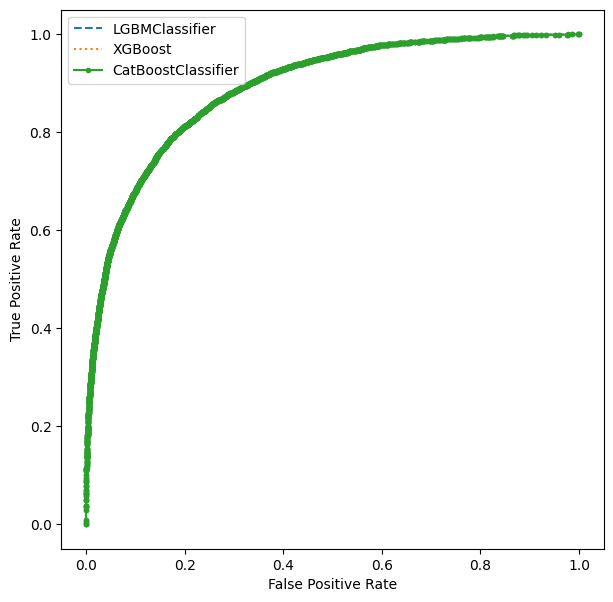

In [ ]:
# 차트 모양
plt.figure( figsize=(7,7))

# 반복
for al_nm, ( model, line_style ) in als.items(): # 알고리즘 이름, 알고리즘객체, 선의 모양
    model.fit( X_train, y_train )                # 학습수행-> 데이터를 경험했다
    # 예측 : [ 0 예측확률, 1 예측확률 ]
    pred = model.predict_proba( X_test )         # 학습에 사용하지 않은 데이터->한번도 접하지 않은
    # 1로 판정한 확률만
    pred_t = pred[ :, -1]
    # 성능평가
    fpr, tpr, _ = roc_curve(y_test.values, pred_t, )
    # 차트그리기 - 플로팅
    plt.plot( fpr, tpr, line_style, label=al_nm)
    # 곡선하면적 계산 제공
    print( al_nm, auc(fpr, tpr))
    pass

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# 결과
# LGBMClassifier     : 0.8910155715776322
# XGBoost            : 0.8884474953207008
# CatBoostClassifier : 0.8903968455281

## 반복작업(학습-예측-성능평가-시각화)

In [ ]:
from sklearn import metrics

# 각 모델의 accuracy, log_loss, auc를 print하는 함수
def print_results(classifier_name, y_test, y_pred, y_pred_proba, fpr, tpr):
    print('Train/Test split results:')
    print(classifier_name + " accuracy is %2.3f" % metrics.accuracy_score(y_test, y_pred))
    print(classifier_name + " log_loss is %2.3f" % metrics.log_loss(y_test, y_pred_proba))
    print(classifier_name + " auc is %2.3f" % metrics.auc(fpr, tpr))

# ROC curve 시각화 함수
def plot_roc_curve(fpr, tpr, classifier_name):
    idx = np.min(np.where(tpr > 0.95))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.7f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(classifier_name + ' ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

results = []

# 각 모델의 accuracy, log_loss 및 auc를 저장하는 함수
def save_accuracy(classifier_name, accuracy, log_loss, auc):
    results.append([classifier_name, accuracy, log_loss, auc])

# 차트
def plot_results():
    df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Log Loss', 'AUC'])
    df_results = df_results.sort_values(by=['Accuracy'], ascending=False)
    df_results = df_results.reset_index(drop=True)
    scaler = MinMaxScaler()
    df_results['Log Loss'] = scaler.fit_transform(df_results['Log Loss'].values.reshape(-1, 1))
    df_results.rename(columns={'Log Loss': 'Log Loss (Normalized)'}, inplace=True)
    df_results.head()
    df_results_sorted = df_results.sort_values(by='AUC')

    bar_width = 0.25
    pos = np.arange(len(df_results_sorted['Model']))
    plt.figure(figsize=(12, 6))
    plt.bar(pos, df_results_sorted['Accuracy'], color='steelblue', width=bar_width, label='Accuracy')
    plt.bar(pos + bar_width, df_results_sorted['Log Loss (Normalized)'], color='limegreen', width=bar_width, label='Log Loss (Normalized)')

    # AUC 그래프 표시
    plt.bar(pos + 2*bar_width, df_results_sorted['AUC'], color='orange', width=bar_width, label='AUC')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Performance')
    plt.xticks(pos + bar_width, df_results_sorted['Model'], rotation=90)
    plt.ylim(0, 1)
    plt.legend()

    for i, auc in enumerate(df_results_sorted['AUC']):
        plt.annotate(f'{auc:.7f}',
                    xy=(pos[i] + 2*bar_width, auc),
                    xytext=(5, 5),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    rotation=90)

    plt.tight_layout()
    plt.show()

### LightGBM

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
Train/Test split results:
LightGBM accuracy is 0.868
LightGBM log_loss is 0.317
LightGBM auc is 0.891


<ipython-input-27-4be2d420b9a1>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
<ipython-input-27-4be2d420b9a1>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')


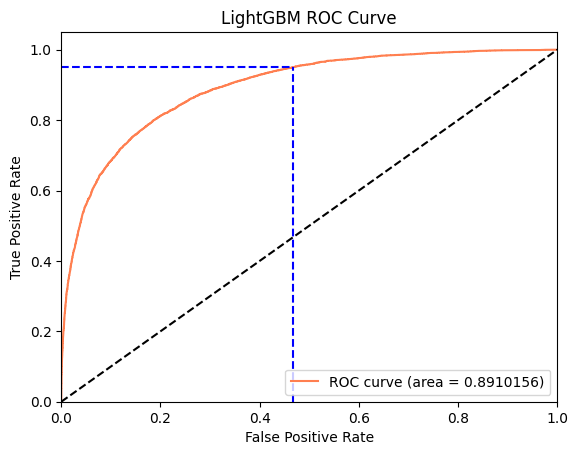

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("LightGBM", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "LightGBM")
save_accuracy("LightGBM", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

### XGBoost

Train/Test split results:
XGBoost accuracy is 0.866
XGBoost log_loss is 0.321
XGBoost auc is 0.888


<ipython-input-27-4be2d420b9a1>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
<ipython-input-27-4be2d420b9a1>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')


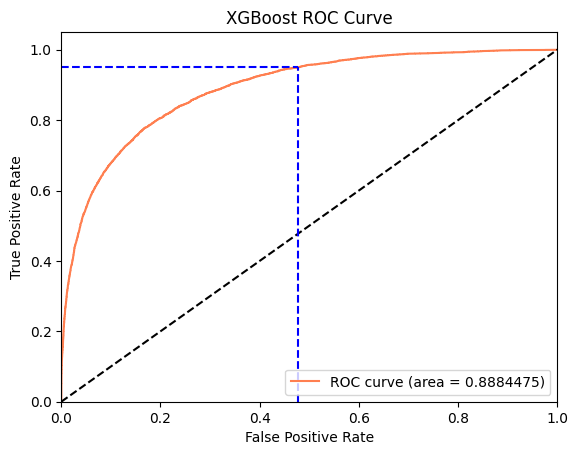

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("XGBoost", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "XGBoost")
save_accuracy("XGBoost", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

### CatBoost

0:	total: 29.5ms	remaining: 1m 43s
1:	total: 55.1ms	remaining: 1m 36s
2:	total: 81.7ms	remaining: 1m 35s
3:	total: 108ms	remaining: 1m 34s
4:	total: 134ms	remaining: 1m 33s
5:	total: 160ms	remaining: 1m 33s
6:	total: 187ms	remaining: 1m 33s
7:	total: 213ms	remaining: 1m 33s
8:	total: 242ms	remaining: 1m 33s
9:	total: 269ms	remaining: 1m 33s
10:	total: 296ms	remaining: 1m 33s
11:	total: 332ms	remaining: 1m 36s
12:	total: 366ms	remaining: 1m 38s
13:	total: 392ms	remaining: 1m 37s
14:	total: 418ms	remaining: 1m 37s
15:	total: 448ms	remaining: 1m 37s
16:	total: 475ms	remaining: 1m 37s
17:	total: 501ms	remaining: 1m 36s
18:	total: 528ms	remaining: 1m 36s
19:	total: 554ms	remaining: 1m 36s
20:	total: 580ms	remaining: 1m 36s
21:	total: 611ms	remaining: 1m 36s
22:	total: 635ms	remaining: 1m 36s
23:	total: 665ms	remaining: 1m 36s
24:	total: 690ms	remaining: 1m 35s
25:	total: 722ms	remaining: 1m 36s
26:	total: 748ms	remaining: 1m 36s
27:	total: 774ms	remaining: 1m 36s
28:	total: 800ms	remaining:

<ipython-input-27-4be2d420b9a1>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
<ipython-input-27-4be2d420b9a1>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')


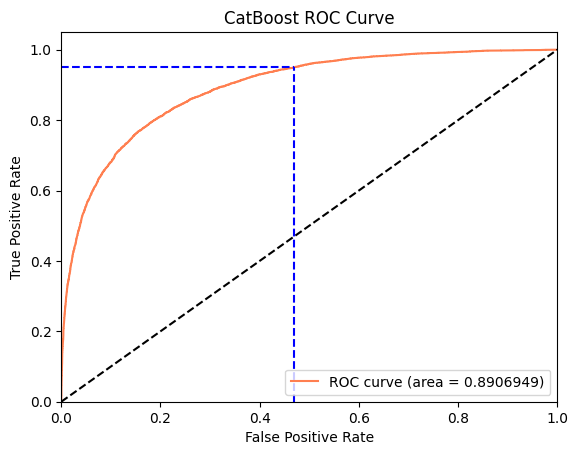

In [ ]:
cb = CatBoostClassifier(eval_metric = 'AUC',learning_rate = 0.0025, iterations= 3500)
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
y_pred_proba = cb.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("CatBoost", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "CatBoost")
save_accuracy("CatBoost", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

# 교차검증+하이퍼파라미터 튜닝

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

params = {
    'n_estimators'  : [100, 500, 1000],      # 반복 횟수
    'learning_rate' : [0.01, 0.05, 0.1],     # 러닝 레이트
    'max_depth'     : [5, 10, 15],           # 최대 깊이
    'subsample'     : [0.6, 0.8, 1]          # 서브샘플 비율
}

CPU times: user 62 µs, sys: 2 µs, total: 64 µs
Wall time: 69.6 µs


- GridSearchCV

In [ ]:
# GridSearchCV 생성
grid_lgbm_model = GridSearchCV(estimator  = lgbm,
                               param_grid = params,
                               scoring    = 'roc_auc',
                               cv         = 5)

# GridSearchCV 학습
grid_lgbm_model.fit(X_train, y_train)

# 베스트모델, 점수
grid_lgbm_model.best_estimator_, grid_lgbm_model.best_score_

# 베스트모델:LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=1000, subsample=0.6)
# 베스트스코어:0.8888488892531299

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

(LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=1000,
                subsample=0.6),
 0.8888488892531299)

- 튜닝

In [ ]:
lgbm_tune = LGBMClassifier(learning_rate = 0.01, max_depth = 15, n_estimators = 1000, subsample = 0.6)
lgbm_tune.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988


LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=1000,
               subsample=0.6)

- Feature Importance

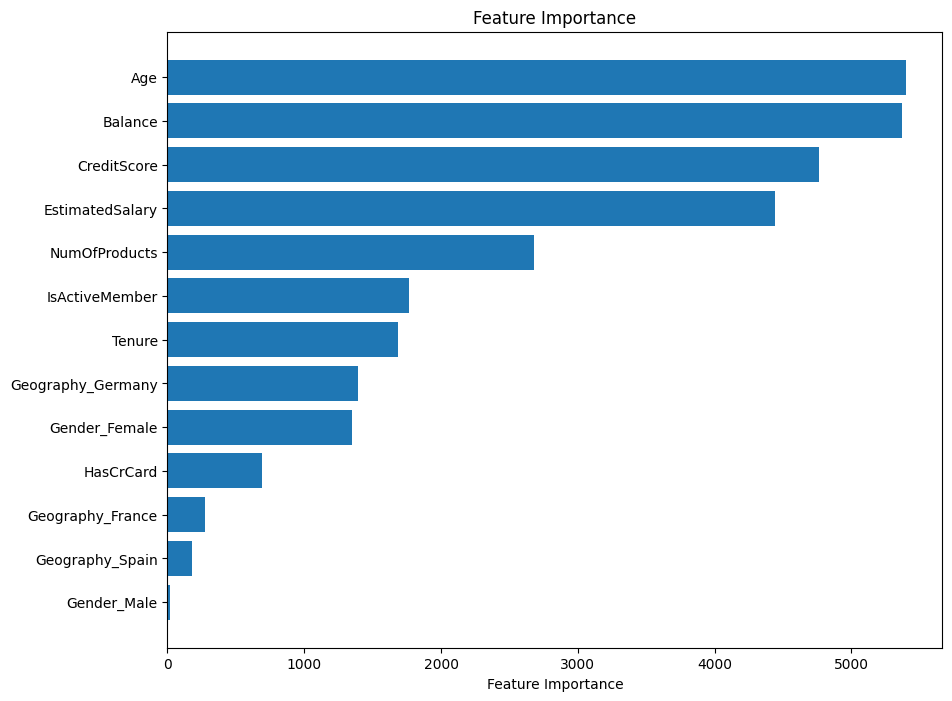

In [ ]:
feature_importances = lgbm_tune.feature_importances_

feature_names = X_train.columns

sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

# 모델적용

In [ ]:
# 테스트 데이터로 모델 성능 확인
from sklearn.metrics import roc_auc_score

y_preds = lgbm_tune.predict_proba(X_test)[:, 1]

# 검증 데이터 ROC AUC
roc_auc_score(y_test, y_preds)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.8913541853968333

In [ ]:
# 예측 수행
pred_sub = lgbm_tune.predict_proba(test_encode)[:,1]

pred_sub

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([0.02473375, 0.83293132, 0.03079632, ..., 0.01937199, 0.13418484,
       0.16788326])

In [ ]:
# 제출 데이터 수정
sample_submission['Exited'] = pred_sub
sample_submission.head(3)

,id,Exited
0,165034,0.024734
1,165035,0.832931
2,165036,0.030796


In [ ]:
# 캐글에 제출할 파일 생성
sample_submission.to_csv('submission4.csv', index=False)